In [3]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from data_generation.data_simulator import IndividualDataSimulator
from data_generation.network_generator import GraphGenerator, NetworkFeatureExtractor
from constants import NetworkSettings, DataGenerationSettings
from methods.methods_est import LinearRegressionEstimator
from methods.visualization import ResultsPlotter, plot_result_graphs, plot_fpr_by_method, plot_bias_with_corruption_overlay
from data_generation.data_simulator import IndividualDataSimulator
from methods.methods_est import PropensityScoreMatcher

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/polinarevina/Library/Caches/pypoetry/virtualenvs/simulations-notebooks-2NAxyaa6-py3.12/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function array> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [4]:
network_settings = NetworkSettings()
dgp_settings = DataGenerationSettings()

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def distort_network(
    adj_matrix,
    edge_removal_prob=0.25,
    edge_addition_prob=0.05,
    edge_swap_frac=0.15,
    node_dropout_prob=0.0
):
    G = nx.from_numpy_array(adj_matrix)
    nodes = list(G.nodes())
    num_edges = G.number_of_edges()

    # 1. Edge removal
    edges = list(G.edges())
    num_remove = int(len(edges) * edge_removal_prob)
    edges_to_remove = np.random.choice(len(edges), num_remove, replace=False)
    for idx in edges_to_remove:
        G.remove_edge(*edges[idx])

    # 2. Edge addition
    num_add = int(num_edges * edge_addition_prob)
    for _ in range(num_add):
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G.has_edge(u, v):
            G.add_edge(u, v)

    # 3. Edge swap (degree-preserving rewiring)
    num_swap = int(num_edges * edge_swap_frac)
    if num_swap > 0:
        G = nx.double_edge_swap(G, nswap=num_swap, max_tries=num_swap * 10)

    # 4. Node dropout
    num_drop = int(len(nodes) * node_dropout_prob)
    if num_drop > 0:
        nodes_to_drop = np.random.choice(nodes, num_drop, replace=False)
        G.remove_nodes_from(nodes_to_drop)

    return nx.to_numpy_array(G)

In [17]:
def degree_shift_analysis(G_orig, G_dist):
    deg_orig = dict(G_orig.degree())
    deg_dist = dict(G_dist.degree())

    deg_diff = {node: abs(deg_orig[node] - deg_dist[node]) for node in G_orig.nodes()}
    diffs = list(deg_diff.values())

    return {
        "Mean degree change": np.mean(diffs),
        "Median degree change": np.median(diffs),
        "Max degree change": np.max(diffs),
        "Min degree change": np.min(diffs),
        "Node with max change": max(deg_diff, key=deg_diff.get)
    }


#### Erdos-Renyi 

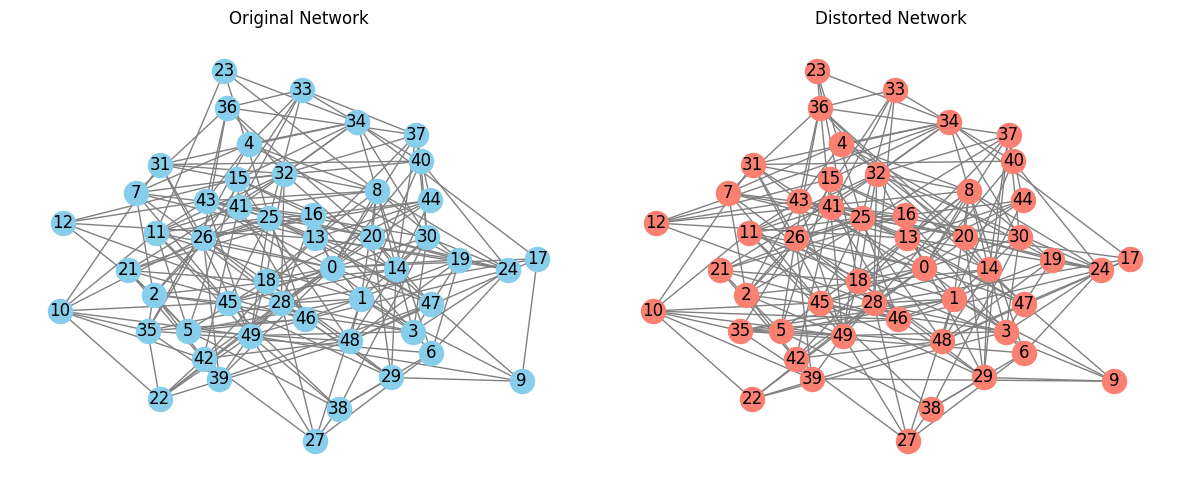

In [24]:
G_orig = nx.erdos_renyi_graph(n=50, p=0.2, seed=1234)
adj_orig = nx.to_numpy_array(G_orig)

adj_distorted = distort_network(
    adj_orig,
    edge_removal_prob=0.1,
    edge_addition_prob=0.05,
    edge_swap_frac=0.05,
    node_dropout_prob=0.0
)

G_distorted = nx.from_numpy_array(adj_distorted)
pos = nx.spring_layout(G_orig, seed=42)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
nx.draw(G_orig, pos=pos, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("Original Network")
plt.subplot(1, 2, 2)
nx.draw(G_distorted, pos=pos, with_labels=True, node_color='salmon', edge_color='gray')
plt.title("Distorted Network")

plt.tight_layout()
plt.show()


In [18]:
degree_shift_analysis(
    G_orig=G_orig,
    G_dist=G_distorted
)

{'Mean degree change': 0.8,
 'Median degree change': 1.0,
 'Max degree change': 3,
 'Min degree change': 0,
 'Node with max change': 1}

### Barabasi Albert graph

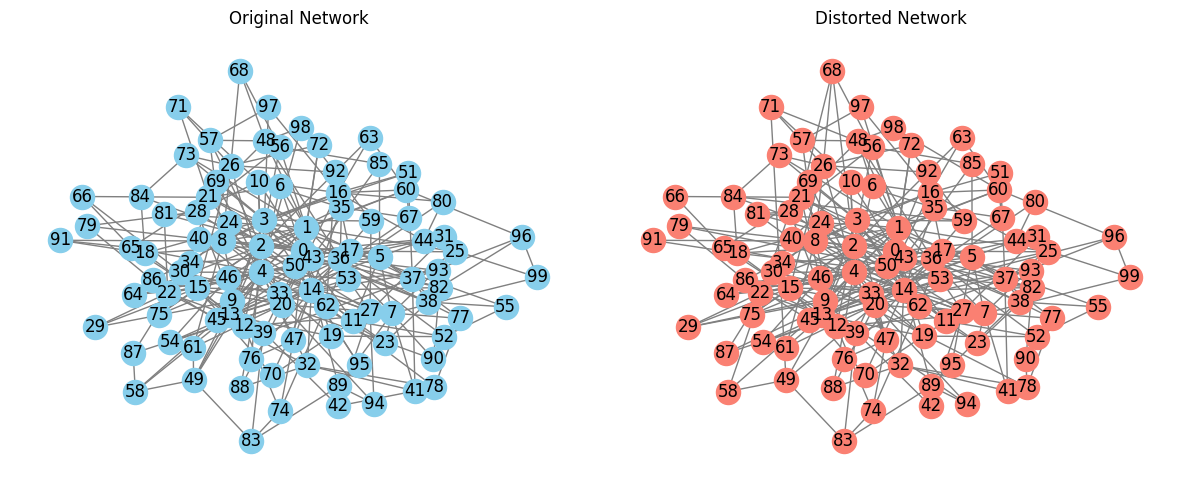

In [23]:
G_orig = nx.barabasi_albert_graph(n=100, m=3, seed=1234)
adj_orig = nx.to_numpy_array(G_orig)

adj_distorted = distort_network(
    adj_orig,
    edge_removal_prob=0.1,
    edge_addition_prob=0.05,
    edge_swap_frac=0.05,
    node_dropout_prob=0.0
)

G_distorted = nx.from_numpy_array(adj_distorted)
pos = nx.spring_layout(G_orig, seed=42)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
nx.draw(G_orig, pos=pos, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("Original Network")
plt.subplot(1, 2, 2)
nx.draw(G_distorted, pos=pos, with_labels=True, node_color='salmon', edge_color='gray')
plt.title("Distorted Network")

plt.tight_layout()
plt.show()


### Watts strogatz graph

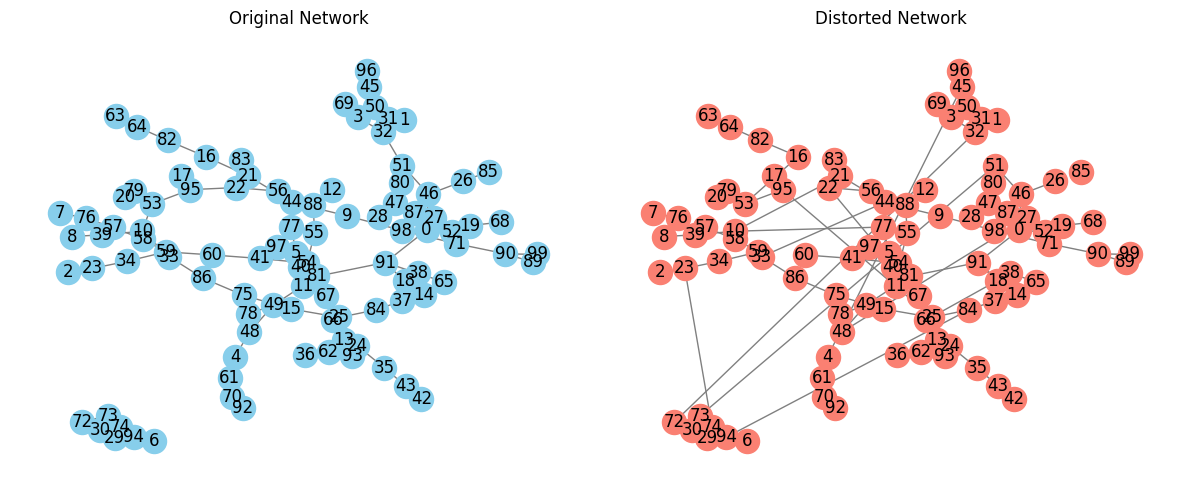

In [26]:
G_orig = nx.watts_strogatz_graph(n=100, k=3, p=0.8)
adj_orig = nx.to_numpy_array(G_orig)

adj_distorted = distort_network(
    adj_orig,
    edge_removal_prob=0.1,
    edge_addition_prob=0.05,
    edge_swap_frac=0.05,
    node_dropout_prob=0.0
)

G_distorted = nx.from_numpy_array(adj_distorted)
pos = nx.spring_layout(G_orig, seed=42)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
nx.draw(G_orig, pos=pos, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("Original Network")
plt.subplot(1, 2, 2)
nx.draw(G_distorted, pos=pos, with_labels=True, node_color='salmon', edge_color='gray')
plt.title("Distorted Network")

plt.tight_layout()
plt.show()
